# CMIコンペ モデル学習・推論・可視化

## 概要
- 前処理済み特徴量データの読み込み・EDA
- LightGBMモデルの学習・推論
- 学習結果の可視化（F1スコア、混同行列、重要度など）
- 予測分布・誤分類例の分析

## 主要処理
- 特徴量データの読み込み・基本統計
- ラベル分布・特徴量分布の可視化
- `src/train_utils.py`の関数呼び出しによる学習・推論
- 学習結果の詳細分析・可視化

In [24]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 8)

print("ライブラリ読み込み完了")

ライブラリ読み込み完了


## Step1: 前処理済み特徴量データの読み込み・基本確認

In [25]:
# 前処理済み特徴量データの読み込み
print("特徴量データ読み込み中...")
train_features = pd.read_csv('../output/train_features.csv')
test_features = pd.read_csv('../output/test_features.csv')

print(f"Train features shape: {train_features.shape}")
print(f"Test features shape: {test_features.shape}")

# 基本情報確認
print("\n=== Train Features Info ===")
print(train_features.info())

print("\n=== Test Features Info ===")
print(test_features.info())

# 先頭表示
print("\n=== Train Features Head ===")
display(train_features.head())

print("\n=== Test Features Head ===")
display(test_features.head())

特徴量データ読み込み中...
Train features shape: (8151, 2326)
Test features shape: (2, 2325)

=== Train Features Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8151 entries, 0 to 8150
Columns: 2326 entries, sequence_id to gesture
dtypes: float64(2324), object(2)
memory usage: 144.6+ MB
None

=== Test Features Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Columns: 2325 entries, sequence_id to tof_5_v63_kurtosis
dtypes: float64(2324), object(1)
memory usage: 36.5+ KB
None

=== Train Features Head ===


,sequence_id,acc_x_mean,acc_x_std,acc_x_min,acc_x_max,acc_x_median,acc_x_skew,acc_y_mean,acc_y_std,acc_y_min,...,tof_5_v55_kurtosis,tof_5_v56_kurtosis,tof_5_v57_kurtosis,tof_5_v58_kurtosis,tof_5_v59_kurtosis,tof_5_v60_kurtosis,tof_5_v61_kurtosis,tof_5_v62_kurtosis,tof_5_v63_kurtosis,gesture
0,SEQ_000007,0.780647,0.230773,0.341328,1.275786,0.838625,-0.545319,0.424639,0.609177,-0.761447,...,-1.972225,16.956214,7.549467,-1.597993,-1.953053,-1.971438,-1.932390,-0.159364,-1.949517,Cheek - pinch skin
1,SEQ_000008,0.304523,0.188046,0.016328,0.737949,0.310922,0.146452,0.703540,0.653100,-0.402355,...,-2.000000,NaN,NaN,NaN,NaN,NaN,-2.000000,NaN,NaN,Forehead - pull hairline
2,SEQ_000013,-1.504681,0.224032,-1.883671,-0.862726,-1.519482,0.518519,0.111008,0.512524,-1.012031,...,21.545025,2.170844,2.662892,47.689935,48.019231,NaN,48.019231,NaN,-2.000000,Cheek - pinch skin
3,SEQ_000016,0.671943,0.185792,0.310922,1.338624,0.648760,0.747648,-1.238862,0.119569,-1.500708,...,0.784359,28.389779,15.888512,15.985942,14.403016,47.206683,9.739453,3.787105,5.513060,Write name on leg
4,SEQ_000018,0.644105,0.281537,0.056193,0.898084,0.771733,-1.397824,0.463441,0.704506,-0.990173,...,0.650247,-1.463188,4.600821,0.287807,0.570865,-0.264038,-0.828885,-0.660049,0.010962,Forehead - pull hairline



=== Test Features Head ===


,sequence_id,acc_x_mean,acc_x_std,acc_x_min,acc_x_max,acc_x_median,acc_x_skew,acc_y_mean,acc_y_std,acc_y_min,...,tof_5_v54_kurtosis,tof_5_v55_kurtosis,tof_5_v56_kurtosis,tof_5_v57_kurtosis,tof_5_v58_kurtosis,tof_5_v59_kurtosis,tof_5_v60_kurtosis,tof_5_v61_kurtosis,tof_5_v62_kurtosis,tof_5_v63_kurtosis
0,SEQ_000001,1.057012,0.181732,0.777138,1.473759,1.002814,0.730955,0.720031,0.470298,-0.201732,...,-1.236246,-0.012234,-0.978589,-1.953183,0.067972,9.170724,-1.882271,-1.436908,-0.610247,-0.61567
1,SEQ_000011,-0.702922,0.611418,-1.066104,1.378489,-0.966780,1.986602,0.965394,0.874892,-1.408593,...,NaN,-2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step2: ラベル分布・特徴量分布の可視化

=== Gesture Distribution ===
gesture
Forehead - pull hairline                      640
Neck - pinch skin                             640
Text on phone                                 640
Neck - scratch                                640
Forehead - scratch                            640
Eyelash - pull hair                           640
Above ear - pull hair                         638
Eyebrow - pull hair                           638
Cheek - pinch skin                            637
Wave hello                                    478
Write name in air                             477
Pull air toward your face                     477
Feel around in tray and pull out an object    161
Write name on leg                             161
Pinch knee/leg skin                           161
Scratch knee/leg skin                         161
Drink from bottle/cup                         161
Glasses on/off                                161
Name: count, dtype: int64

ユニークなジェスチャー数: 18


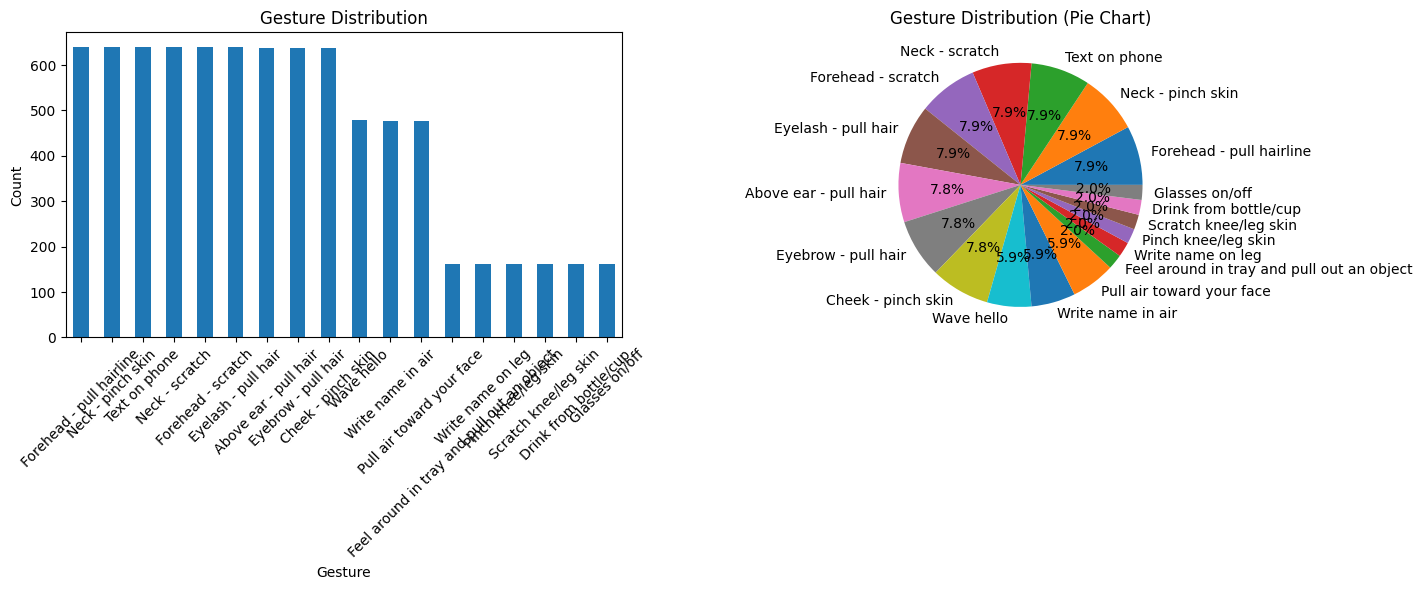

In [26]:
# ラベル分布の確認
print("=== Gesture Distribution ===")
gesture_counts = train_features['gesture'].value_counts()
print(gesture_counts)
print(f"\nユニークなジェスチャー数: {len(gesture_counts)}")

# ラベル分布の可視化
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
gesture_counts.plot(kind='bar')
plt.title('Gesture Distribution')
plt.xlabel('Gesture')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
gesture_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Gesture Distribution (Pie Chart)')
plt.ylabel('')

plt.tight_layout()
plt.show()

特徴量数: 2324

=== Feature Statistics ===
        acc_x_mean    acc_x_std    acc_x_min    acc_x_max  acc_x_median  \
count  8151.000000  8151.000000  8151.000000  8151.000000   8151.000000   
mean     -0.050888     0.573244    -1.004888     1.199421     -0.135261   
std       0.763414     0.354084     1.065267     0.756268      0.927373   
min      -1.936444     0.021475    -6.266100    -1.845833     -1.969482   
25%      -0.665009     0.267976    -1.866103     0.879503     -0.930293   
50%       0.025162     0.498733    -1.003942     1.342003     -0.002591   
75%       0.608523     0.828524    -0.086037     1.645043      0.679165   
max       1.393460     3.033648     1.175786     7.729836      1.408894   

        acc_x_skew   acc_y_mean    acc_y_std    acc_y_min    acc_y_max  ...  \
count  8151.000000  8151.000000  8151.000000  8151.000000  8151.000000  ...   
mean      0.338113     0.045948     0.646424    -1.121746     1.030017  ...   
std       1.119004     0.704510     0.299984    

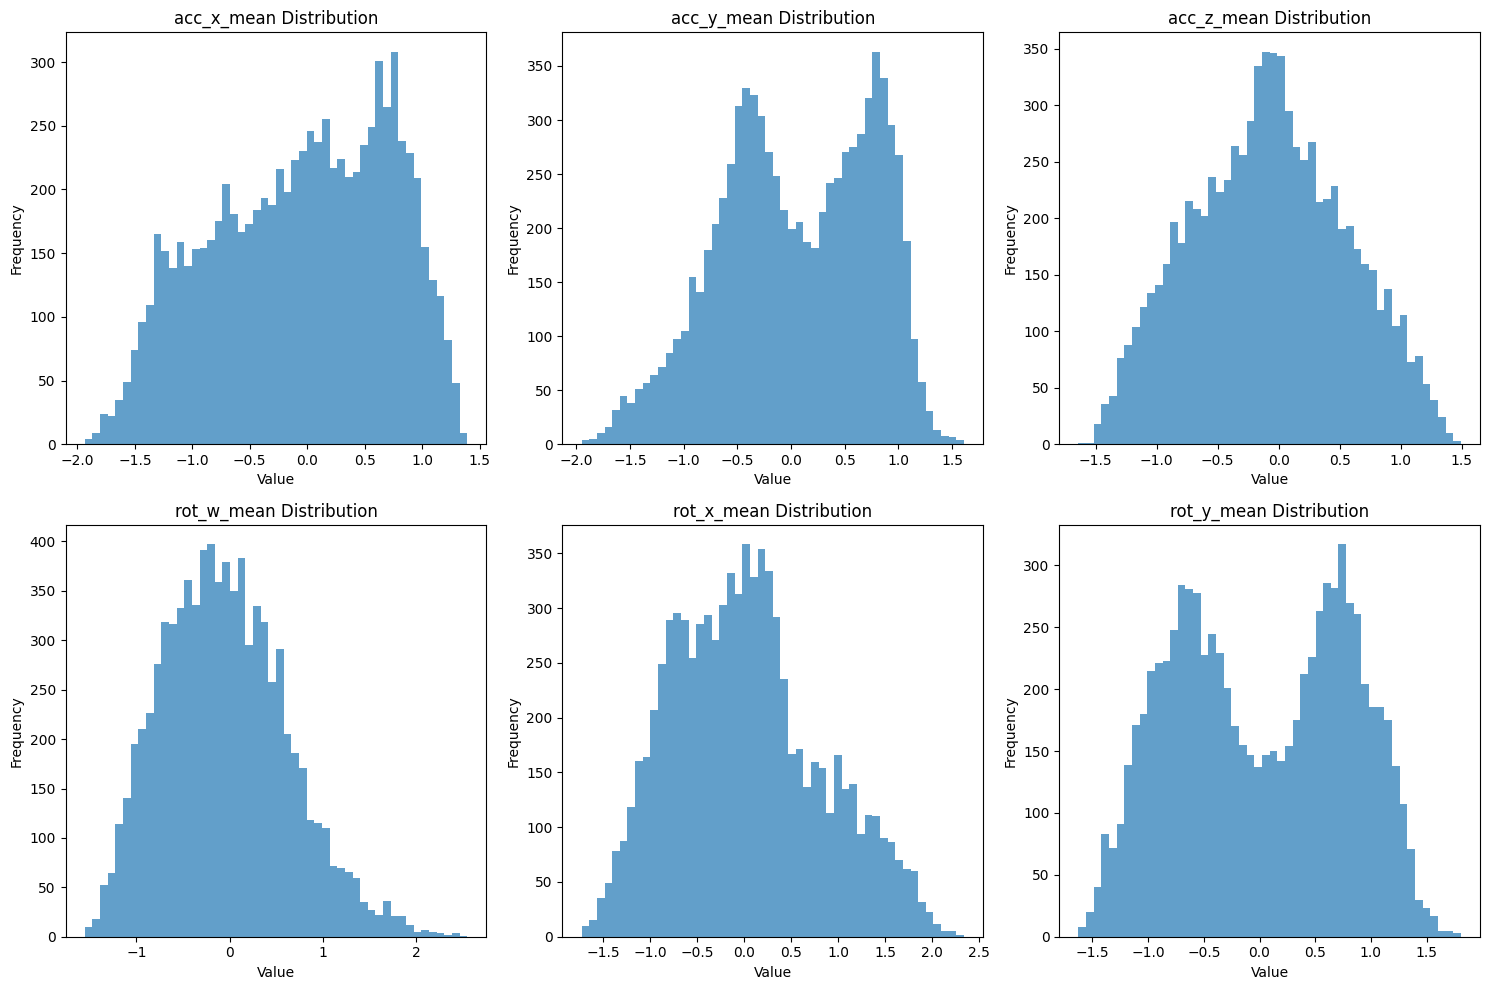

In [27]:
# 特徴量の基本統計・分布確認
feature_cols = [col for col in train_features.columns if col not in ['sequence_id', 'gesture']]
print(f"特徴量数: {len(feature_cols)}")

# 特徴量の基本統計
print("\n=== Feature Statistics ===")
feature_stats = train_features[feature_cols].describe()
print(feature_stats)

# 代表的な特徴量の分布可視化
plt.figure(figsize=(15, 10))

# 加速度センサーの特徴量（平均値）
acc_mean_features = [col for col in feature_cols if 'acc_' in col and 'mean' in col]
for i, feature in enumerate(acc_mean_features[:3]):
    plt.subplot(2, 3, i+1)
    plt.hist(train_features[feature], bins=50, alpha=0.7)
    plt.title(f'{feature} Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

# 回転センサーの特徴量（平均値）
rot_mean_features = [col for col in feature_cols if 'rot_' in col and 'mean' in col]
for i, feature in enumerate(rot_mean_features[:3]):
    plt.subplot(2, 3, i+4)
    plt.hist(train_features[feature], bins=50, alpha=0.7)
    plt.title(f'{feature} Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

## Step3: train_utils.pyの関数呼び出しによる学習・推論

In [28]:
# train_utils.pyの関数をインポート
import sys
sys.path.append('../src')
from train_utils import (
    load_data, prepare_data, train_model_detailed, predict_test_detailed, 
    create_submission_detailed, generate_performance_report,
    analyze_feature_importance, create_confusion_matrix_analysis
)

print("train_utils.pyの関数読み込み完了")

train_utils.pyの関数読み込み完了


In [29]:
# データ準備
print("データ準備中...")
X_train, y_train, X_test, le, feature_cols = prepare_data(train_features, test_features)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"Classes: {le.classes_}")

データ準備中...
Features: 2324
Classes: 18
Class distribution: [638 637 161 638 640 161 640 640 161 640 640 161 477 161 640 478 477 161]
X_train shape: (8151, 2324)
X_test shape: (2, 2324)
y_train shape: (8151,)
Classes: ['Above ear - pull hair' 'Cheek - pinch skin' 'Drink from bottle/cup'
 'Eyebrow - pull hair' 'Eyelash - pull hair'
 'Feel around in tray and pull out an object' 'Forehead - pull hairline'
 'Forehead - scratch' 'Glasses on/off' 'Neck - pinch skin'
 'Neck - scratch' 'Pinch knee/leg skin' 'Pull air toward your face'
 'Scratch knee/leg skin' 'Text on phone' 'Wave hello' 'Write name in air'
 'Write name on leg']


In [30]:
# モデル学習（詳細版）
print("モデル学習開始...")
detailed_results = train_model_detailed(X_train, y_train, feature_cols, n_folds=5)

print(f"\n学習完了!")
print(f"CV Score: {detailed_results['mean_score']:.4f} (+/- {detailed_results['std_score']:.4f})")

モデル学習開始...

--------------------------------------------------
LightGBMモデル訓練開始（詳細版）
--------------------------------------------------

Fold 1/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.15568
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 1.14002
Fold 1 F1 Score: 0.5962

Fold 2/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.13917
Early stopping, best iteration is:
[139]	valid_0's multi_logloss: 1.12085
Fold 2 F1 Score: 0.5843

Fold 3/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.1759
Early stopping, best iteration is:
[115]	valid_0's multi_logloss: 1.1676
Fold 3 F1 Score: 0.5970

Fold 4/5
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 1.24912
Early stopping, best iteration is:
[124]	valid_0's multi_logloss: 1.24185
Fold 4 F1 Score: 0.5624

Fold 5/5
Training until validation

In [40]:
# テストデータでの予測（詳細版）
print("テストデータでの予測中...")
predictions, probabilities = predict_test_detailed(detailed_results['models'], X_test, le)

# 提出ファイル作成（詳細版）
submission = create_submission_detailed(test_features, predictions, probabilities)

print(f"\n予測完了!")
print(f"Submission shape: {submission.shape}")

テストデータでの予測中...

テストデータでの予測中...

提出ファイル作成中...
提出ファイル保存: ../output/submission.csv
Submission shape: (2, 20)

予測分布:
gesture
Forehead - pull hairline    1
Eyelash - pull hair         1
Name: count, dtype: int64

予測完了!
Submission shape: (2, 20)


## Step4: 学習結果の詳細分析・可視化

In [41]:
# 詳細性能レポート生成
performance_report = generate_performance_report(detailed_results, le, predictions)

# 結果を変数に格納
importance_df = performance_report['importance_df']
sensor_importance = performance_report['sensor_importance']
confusion_matrix_cv = performance_report['confusion_matrix']
class_performance = performance_report['class_performance']


詳細性能レポート

クロスバリデーション結果:
  平均F1スコア: 0.5890
  標準偏差: 0.0148
  各foldスコア: ['0.5962', '0.5843', '0.5970', '0.5624', '0.6050']

特徴量重要度 (Top 10):
  1. acc_y_max: 12681.9334 (±1452.0389)
  2. thm_2_median: 9472.2651 (±722.7246)
  3. thm_3_median: 6255.7113 (±786.9480)
  4. thm_2_mean: 6182.3966 (±964.1182)
  5. rot_y_std: 4876.8878 (±100.7435)
  6. acc_z_min: 4272.3645 (±290.8216)
  7. thm_2_max: 4236.4029 (±284.5115)
  8. acc_x_min: 4064.5258 (±345.5350)
  9. thm_1_median: 2955.7566 (±759.7398)
  10. rot_x_mean: 2540.3305 (±651.7184)

センサー別重要度:
  Accelerometer: 2008.6272
  Rotation: 1008.4639
  Thermal: 1211.7626
  ToF: 98.5460

クラス別性能:
  Above ear - pull hair: F1=0.7211, Support=638
  Cheek - pinch skin: F1=0.5457, Support=637
  Drink from bottle/cup: F1=0.8000, Support=161
  Eyebrow - pull hair: F1=0.4369, Support=638
  Eyelash - pull hair: F1=0.4977, Support=640
  Feel around in tray and pull out an object: F1=0.9276, Support=161
  Forehead - pull hairline: F1=0.6319, Support=640
  Forehea

=== Cross-validation Results Analysis ===
Mean F1 Score: 0.5890
Std F1 Score: 0.0148
Individual fold scores: ['0.5962', '0.5843', '0.5970', '0.5624', '0.6050']
95% Confidence Interval: 0.5890 ± 0.0291


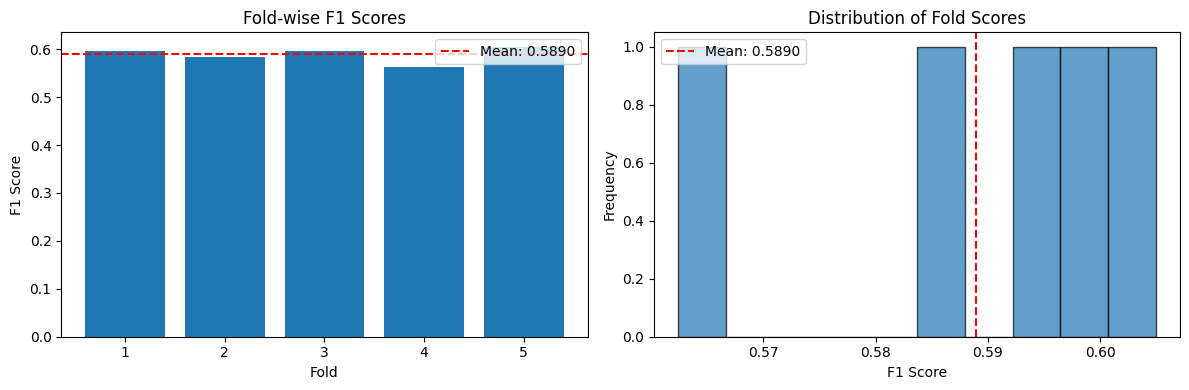

In [42]:
# クロスバリデーション結果の詳細分析
print("=== Cross-validation Results Analysis ===")

fold_scores = detailed_results['fold_scores']
mean_score = detailed_results['mean_score']
std_score = detailed_results['std_score']

print(f"Mean F1 Score: {mean_score:.4f}")
print(f"Std F1 Score: {std_score:.4f}")
print(f"Individual fold scores: {[f'{score:.4f}' for score in fold_scores]}")

# スコアの信頼区間
confidence_interval = 1.96 * std_score  # 95%信頼区間
print(f"95% Confidence Interval: {mean_score:.4f} ± {confidence_interval:.4f}")

# スコアの可視化
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.bar(range(1, len(fold_scores)+1), fold_scores)
plt.axhline(y=mean_score, color='r', linestyle='--', label=f'Mean: {mean_score:.4f}')
plt.title('Fold-wise F1 Scores')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(fold_scores, bins=10, alpha=0.7, edgecolor='black')
plt.axvline(x=mean_score, color='r', linestyle='--', label=f'Mean: {mean_score:.4f}')
plt.title('Distribution of Fold Scores')
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

=== Feature Importance Analysis ===
Top 20 Most Important Features:
              feature    importance  std_importance
9           acc_y_max  12681.933397     1452.038854
52       thm_2_median   9472.265088      722.724628
58       thm_3_median   6255.711332      786.948039
48         thm_2_mean   6182.396552      964.118237
31          rot_y_std   4876.887778      100.743469
14          acc_z_min   4272.364462      290.821601
51          thm_2_max   4236.402882      284.511535
2           acc_x_min   4064.525832      345.535032
46       thm_1_median   2955.756566      759.739808
24         rot_x_mean   2540.330506      651.718392
1           acc_x_std   2432.008970      256.160548
40       rot_z_median   2326.951529      366.828167
0          acc_x_mean   2260.698718      249.428329
37          rot_z_std   2238.997107      565.053786
6          acc_y_mean   1977.131717      178.009490
16       acc_z_median   1963.847362      269.469240
33          rot_y_max   1820.657733      169.421

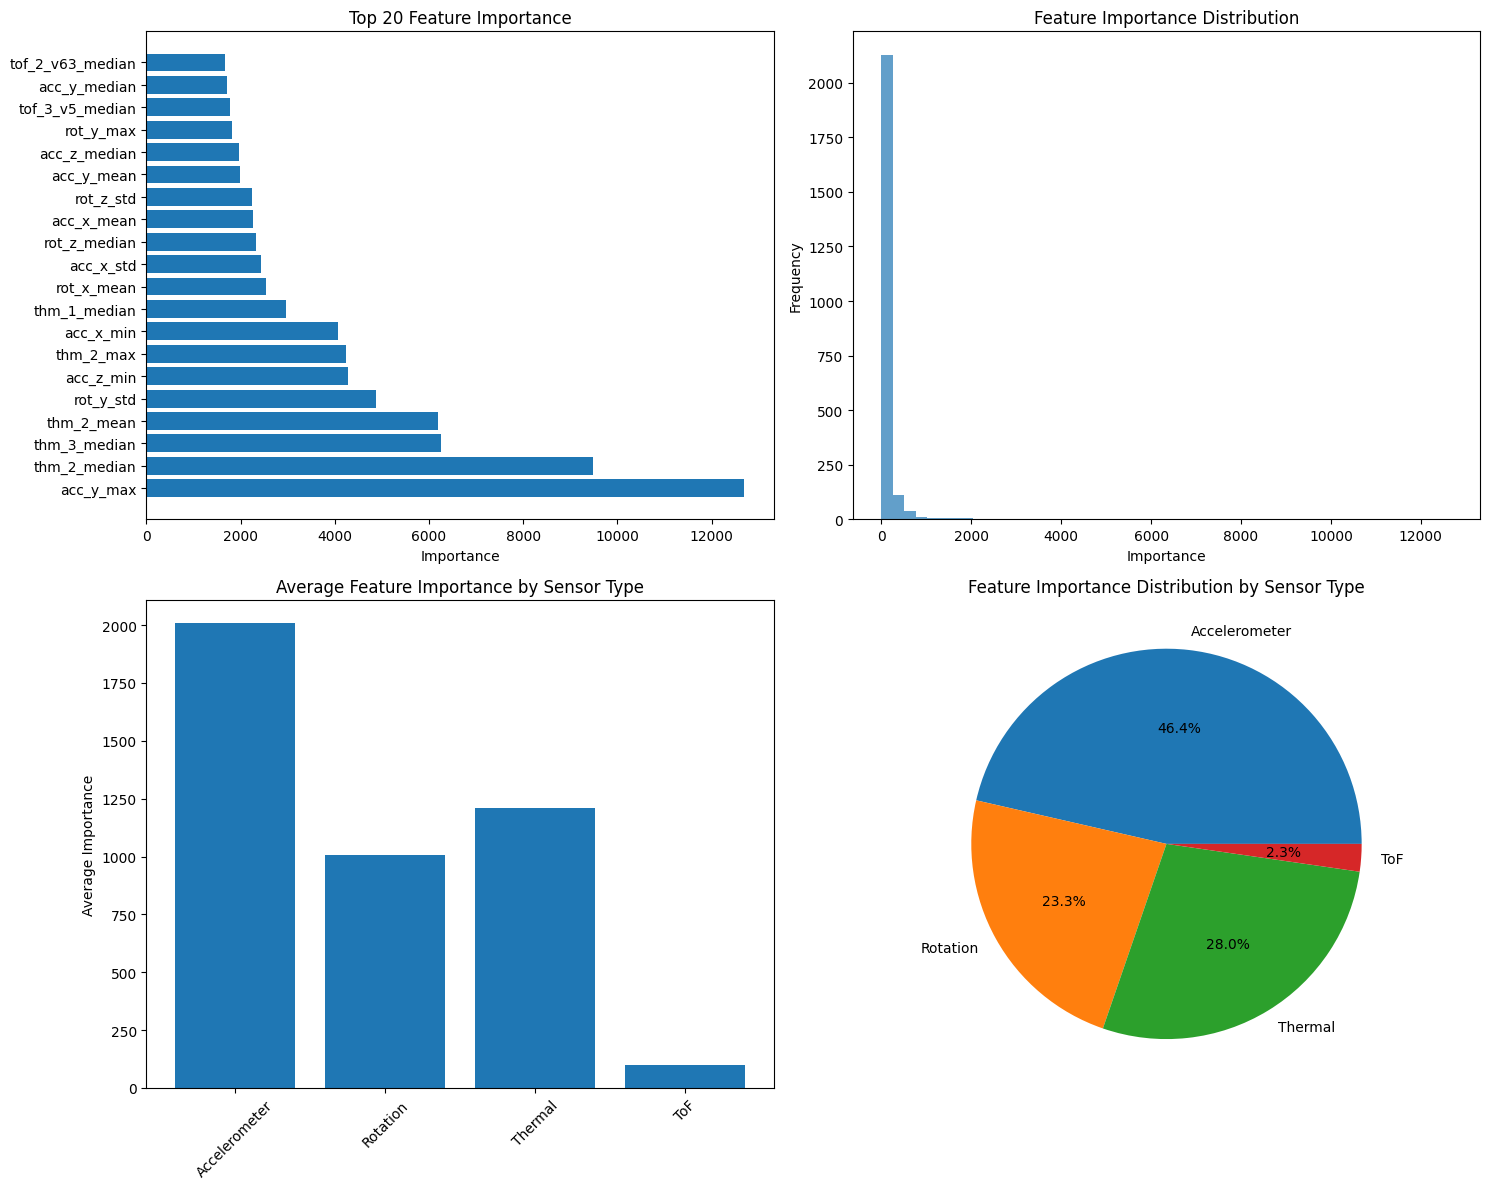

In [43]:
# 特徴量重要度の可視化
print("=== Feature Importance Analysis ===")

print("Top 20 Most Important Features:")
print(importance_df.head(20))

# 重要度の可視化
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.title('Top 20 Feature Importance')
plt.xlabel('Importance')

plt.subplot(2, 2, 2)
plt.hist(importance_df['importance'], bins=50, alpha=0.7)
plt.title('Feature Importance Distribution')
plt.xlabel('Importance')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
sensors = list(sensor_importance.keys())
avg_importances = list(sensor_importance.values())
plt.bar(sensors, avg_importances)
plt.title('Average Feature Importance by Sensor Type')
plt.ylabel('Average Importance')
plt.xticks(rotation=45)

plt.subplot(2, 2, 4)
plt.pie(avg_importances, labels=sensors, autopct='%1.1f%%')
plt.title('Feature Importance Distribution by Sensor Type')

plt.tight_layout()
plt.show()

=== Confusion Matrix Analysis ===


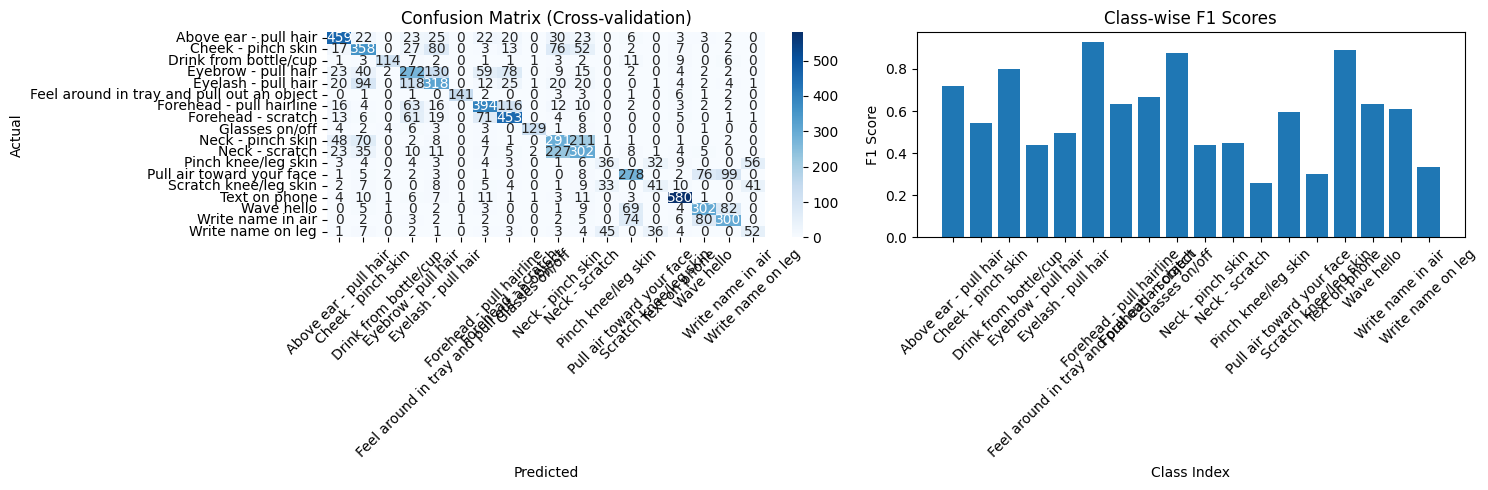


Class-wise Performance:
Above ear - pull hair: F1=0.7211, Support=638
Cheek - pinch skin: F1=0.5457, Support=637
Drink from bottle/cup: F1=0.8000, Support=161
Eyebrow - pull hair: F1=0.4369, Support=638
Eyelash - pull hair: F1=0.4977, Support=640
Feel around in tray and pull out an object: F1=0.9276, Support=161
Forehead - pull hairline: F1=0.6319, Support=640
Forehead - scratch: F1=0.6647, Support=640
Glasses on/off: F1=0.8746, Support=161
Neck - pinch skin: F1=0.4386, Support=640
Neck - scratch: F1=0.4494, Support=640
Pinch knee/leg skin: F1=0.2609, Support=161
Pull air toward your face: F1=0.5953, Support=477
Scratch knee/leg skin: F1=0.3015, Support=161
Text on phone: F1=0.8916, Support=640
Wave hello: F1=0.6338, Support=478
Write name in air: F1=0.6116, Support=477
Write name on leg: F1=0.3333, Support=161


In [44]:
# 混同行列の可視化
print("=== Confusion Matrix Analysis ===")

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix_cv, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix (Cross-validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.subplot(1, 2, 2)
# クラス別F1スコアの可視化
plt.bar(range(len(class_performance)), class_performance['f1_score'])
plt.title('Class-wise F1 Scores')
plt.xlabel('Class Index')
plt.ylabel('F1 Score')
plt.xticks(range(len(class_performance)), le.classes_, rotation=45)

plt.tight_layout()
plt.show()

# クラス別性能の詳細表示
print("\nClass-wise Performance:")
for _, row in class_performance.iterrows():
    print(f"{row['class']}: F1={row['f1_score']:.4f}, Support={row['support']}")

=== Prediction Distribution Analysis ===


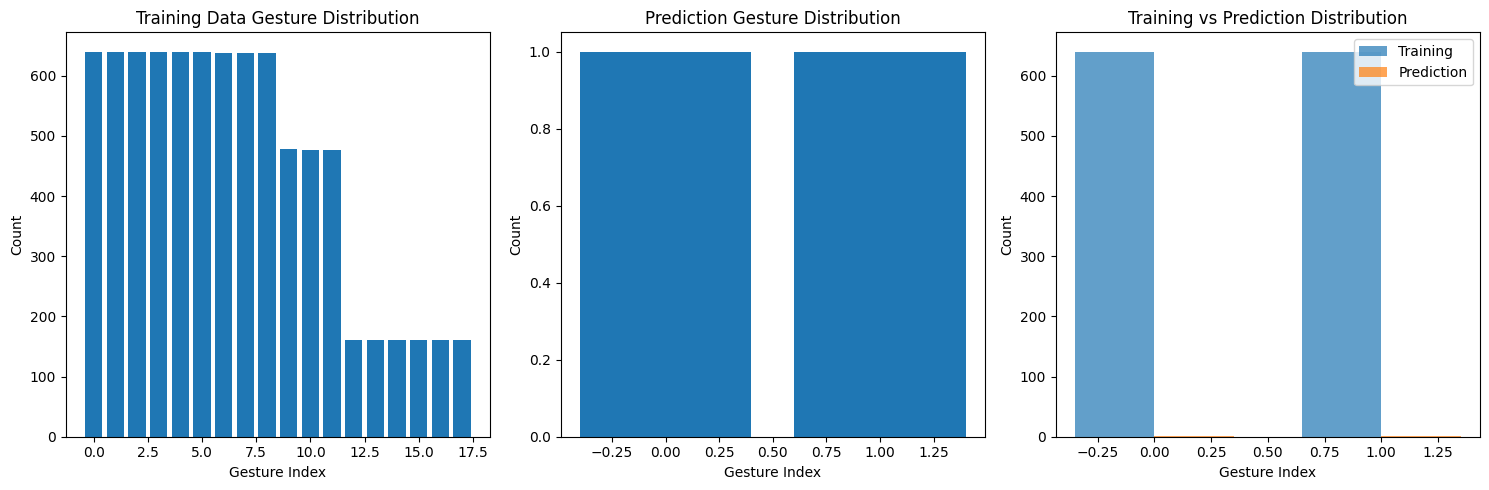

In [45]:
# 予測分布の分析
print("=== Prediction Distribution Analysis ===")

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
train_gesture_counts = train_features['gesture'].value_counts()
plt.bar(range(len(train_gesture_counts)), train_gesture_counts.values)
plt.title('Training Data Gesture Distribution')
plt.xlabel('Gesture Index')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
pred_gesture_counts = submission['gesture'].value_counts()
plt.bar(range(len(pred_gesture_counts)), pred_gesture_counts.values)
plt.title('Prediction Gesture Distribution')
plt.xlabel('Gesture Index')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
# 訓練データと予測データの分布比較
common_gestures = set(train_gesture_counts.index) & set(pred_gesture_counts.index)
train_common = train_gesture_counts.loc[list(common_gestures)]
pred_common = pred_gesture_counts.loc[list(common_gestures)]

x = np.arange(len(common_gestures))
width = 0.35
plt.bar(x - width/2, train_common.values, width, label='Training', alpha=0.7)
plt.bar(x + width/2, pred_common.values, width, label='Prediction', alpha=0.7)
plt.title('Training vs Prediction Distribution')
plt.xlabel('Gesture Index')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

In [46]:
# モデルの学習曲線（最初のモデルから）
print("=== Learning Curves ===")

first_model = detailed_results['models'][0]
if hasattr(first_model, 'evals_result'):
    evals_result = first_model.evals_result()
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    if 'valid_0' in evals_result:
        train_loss = evals_result['training']['multi_logloss']
        valid_loss = evals_result['valid_0']['multi_logloss']
        plt.plot(train_loss, label='Training Loss')
        plt.plot(valid_loss, label='Validation Loss')
        plt.title('Learning Curves (Loss)')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.legend()
    
    plt.subplot(1, 2, 2)
    if 'valid_0' in evals_result:
        train_metric = evals_result['training']['multi_logloss']
        valid_metric = evals_result['valid_0']['multi_logloss']
        plt.plot(train_metric, label='Training Metric')
        plt.plot(valid_metric, label='Validation Metric')
        plt.title('Learning Curves (Metric)')
        plt.xlabel('Iteration')
        plt.ylabel('Metric')
        plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("学習履歴の詳細情報は利用できません")

=== Learning Curves ===
学習履歴の詳細情報は利用できません


In [47]:
# 実験結果の記録・保存
import sys
sys.path.append('../src')

from experiment_logger import log_experiment_results

# 現在の実験結果を記録
experiment_name = "baseline_lightgbm_v1"

# 必要な変数が定義されているか確認
print("変数確認:")
print(f"detailed_results: {'詳細結果' if 'detailed_results' in locals() else '未定義'}")
print(f"performance_report: {'性能レポート' if 'performance_report' in locals() else '未定義'}")
print(f"submission: {'提出ファイル' if 'submission' in locals() else '未定義'}")
print(f"le: {'ラベルエンコーダー' if 'le' in locals() else '未定義'}")

# 実験記録実行
if 'performance_report' in locals():
    logger = log_experiment_results(
        experiment_name=experiment_name,
        detailed_results=detailed_results,
        performance_report=performance_report,
        submission=submission,
        models=detailed_results['models'],
        le=le,
        params={
            'objective': 'multiclass',
            'num_class': len(le.classes_),
            'metric': 'multi_logloss',
            'boosting_type': 'gbdt',
            'num_leaves': 31,
            'learning_rate': 0.05,
            'feature_fraction': 0.9,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1,
            'random_state': 42
        },
        train_shape=train_features.shape,
        test_shape=test_features.shape
    )
    
    print(f"実験結果が保存されました: {logger.experiment_dir}")
else:
    print("performance_reportが未定義です。詳細分析セルを先に実行してください。")

変数確認:
detailed_results: 詳細結果
performance_report: 性能レポート
submission: 提出ファイル
le: ラベルエンコーダー
実験ロガー初期化完了: ../output/experiments/baseline_lightgbm_v1
パラメータ記録完了: 11個のパラメータ
データ情報記録完了: 2324特徴量, 18クラス
学習結果記録完了: CV Score = 0.5890 (±0.0148)
特徴量重要度記録完了: 2324特徴量
分類結果記録完了: 18クラス
予測結果記録完了: 2サンプル
モデル保存完了: 5個のモデル
実験完了: ../output/experiments/baseline_lightgbm_v1
ステータス: completed
実験結果が保存されました: ../output/experiments/baseline_lightgbm_v1


## Step5: 結果サマリー

In [48]:
# 結果サマリー
print("="*60)
print("CMIコンペ モデル学習・推論結果サマリー")
print("="*60)

print(f"\nデータ情報:")
print(f"  訓練データ: {train_features.shape[0]} シークエンス, {len(feature_cols)} 特徴量")
print(f"  テストデータ: {test_features.shape[0]} シークエンス")
print(f"  クラス数: {len(le.classes_)}")

print(f"\nモデル性能:")
print(f"  CV F1 Score: {mean_score:.4f} (+/- {std_score:.4f})")
print(f"  95%信頼区間: {mean_score:.4f} ± {1.96 * std_score:.4f}")
print(f"  各foldスコア: {[f'{score:.4f}' for score in fold_scores]}")

print(f"\n特徴量重要度 (Top 5):")
for i, (_, row) in enumerate(importance_df.head(5).iterrows()):
    print(f"  {i+1}. {row['feature']}: {row['importance']:.4f} (±{row['std_importance']:.4f})")

print(f"\nセンサー別重要度:")
for sensor, importance in sensor_importance.items():
    print(f"  {sensor}: {importance:.4f}")

print(f"\nクラス別性能 (Top 5):")
top_classes = class_performance.nlargest(5, 'f1_score')
for _, row in top_classes.iterrows():
    print(f"  {row['class']}: F1={row['f1_score']:.4f}, Support={row['support']}")

print(f"\n提出ファイル:")
print(f"  保存先: ../output/submission.csv")
print(f"  予測サンプル数: {submission.shape[0]}")
print(f"  予測クラス数: {submission['gesture'].nunique()}")

print("\n" + "="*60)

CMIコンペ モデル学習・推論結果サマリー

データ情報:
  訓練データ: 8151 シークエンス, 2324 特徴量
  テストデータ: 2 シークエンス
  クラス数: 18

モデル性能:
  CV F1 Score: 0.5890 (+/- 0.0148)
  95%信頼区間: 0.5890 ± 0.0291
  各foldスコア: ['0.5962', '0.5843', '0.5970', '0.5624', '0.6050']

特徴量重要度 (Top 5):
  1. acc_y_max: 12681.9334 (±1452.0389)
  2. thm_2_median: 9472.2651 (±722.7246)
  3. thm_3_median: 6255.7113 (±786.9480)
  4. thm_2_mean: 6182.3966 (±964.1182)
  5. rot_y_std: 4876.8878 (±100.7435)

センサー別重要度:
  Accelerometer: 2008.6272
  Rotation: 1008.4639
  Thermal: 1211.7626
  ToF: 98.5460

クラス別性能 (Top 5):
  Feel around in tray and pull out an object: F1=0.9276, Support=161
  Text on phone: F1=0.8916, Support=640
  Glasses on/off: F1=0.8746, Support=161
  Drink from bottle/cup: F1=0.8000, Support=161
  Above ear - pull hair: F1=0.7211, Support=638

提出ファイル:
  保存先: ../output/submission.csv
  予測サンプル数: 2
  予測クラス数: 2

